In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn import linear_model
import shap

In [41]:
x = pd.read_csv("../data/shops_data.csv")
x.drop(x.columns[0], axis=1, inplace=True)
x.head()

,liczba budynków – suma,liczba budynków - mieszkalnych,liczba mieszkań - mieszkalnych według DataWise,szacowana liczba mieszkańców razem,średnia liczba osób na gospodarstwo domowe,gęstość zaludnienia osób na km2,szacowany średni wiek mieszkańców razem,populacja - procent kobiet,populacja - procent mężczyzn,przykład: 4.13,...,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - miejsca kultu (kościół),odległość w metrach do najbliższego POI (-1 = większa niż 5000 m) - poczta (poczta),odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - rozrywka i kult,odległość w metrach do najbliższego POI (-1 = większe niż 5000 m) - stacja benzynowa (stacja paliw),odległość w metrach do najbliższego punktu POI (-1 = większa niż 5000 m) - suma transportu,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - stacja kolejowa transportu,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - zatrzymuje się transport,odległość w metrach do najbliższego POI (-1 = więcej niż 5000 m) - biuro / administracja publiczna,odległość w metrach do najbliższego POI (-1 = więcej niż 5000 m) - suma zdrowia,odległość w metrach do najbliższego POI (-1 = większy niż 5000 m) - apteka zdrowia
0,389.0,333.0,879.0,2447.0,3.10,7456.0,43.2,52.80,47.20,4.17,...,50.0,457.0,457.0,1161.0,103.0,2378.0,103.0,1217.0,200.0,420.0
1,215.0,166.0,766.0,1848.0,2.50,6752.0,45.1,55.03,44.97,3.41,...,362.0,77.0,2572.0,242.0,63.0,580.0,63.0,1464.0,0.0,0.0
2,317.0,183.0,2397.0,4702.0,2.19,18884.0,41.0,54.91,45.09,7.04,...,95.0,197.0,358.0,412.0,138.0,1400.0,158.0,406.0,57.0,57.0
3,21.0,7.0,52.0,212.0,2.41,2332.0,34.6,36.32,63.68,5.19,...,751.0,252.0,255.0,472.0,204.0,1287.0,204.0,1168.0,89.0,179.0
4,64.0,33.0,799.0,1900.0,2.41,11243.0,45.4,54.68,45.32,3.11,...,542.0,488.0,294.0,893.0,128.0,2986.0,128.0,2081.0,66.0,66.0


In [42]:
y = pd.read_csv("../data/product1.csv")
y.drop(y.columns[0], axis=1, inplace=True)
y.rename(columns={"0": "sales"}, inplace=True)
y.head()

,sales
0,937.082216
1,934.259920
2,950.416245
3,2037.501329
4,954.503685


In [43]:
x_background_dist = x[:100]
x = x[100:]
y = y[100:]

In [44]:
X_train, X_test, y_train, y_test = train_test_split(x, y.values, test_size=0.2, random_state=0)

In [45]:
np.mean(y_test), np.std(y_test)

(np.float64(2899.0673974711667), np.float64(348.35615407409256))

In [46]:
lin_regr = linear_model.LinearRegression()
lin_regr.fit(X_train, y_train)

LinearRegression()

In [47]:
np.sqrt(np.mean((lin_regr.predict(X_test) - y_test) ** 2))

np.float64(6.0757110228180435)

In [50]:
explainer = shap.Explainer(lin_regr.predict, x_background_dist)
shap_values = explainer(X_test) 

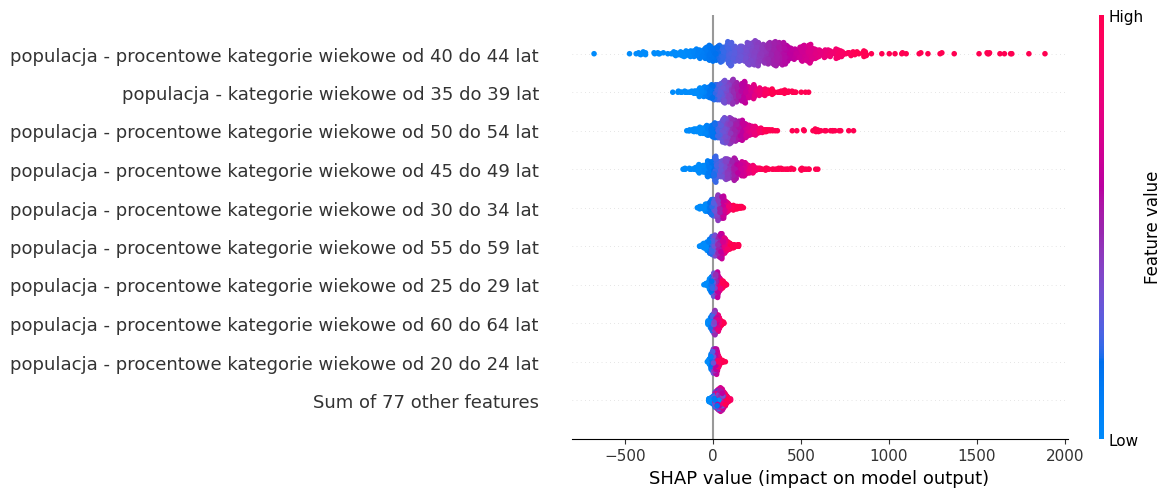

In [51]:
shap.plots.beeswarm(shap_values)

In [54]:
mean_shape_values = shap_values.mean(0).values
feature_importance_by_shapley = dict((zip(X_test.columns, mean_shape_values)))
feature_importance_by_shapley["populacja - procentowe kategorie wiekowe od 40 do 44 lat"], feature_importance_by_shapley["populacja - procentowe kategorie wiekowe od 20 do 24 lat"]

(np.float64(308.1928958162872), np.float64(12.528554282449715))

In [75]:
feature_importance_by_shapley

{'liczba budynków – suma': np.float64(-0.0802022610890151),
 'liczba budynków - mieszkalnych': np.float64(-0.11813283153142029),
 'liczba mieszkań - mieszkalnych według DataWise': np.float64(-0.06466317266793693),
 'szacowana liczba mieszkańców razem': np.float64(-0.0342166587256882),
 'średnia liczba osób na gospodarstwo domowe': np.float64(-0.020194375277518616),
 'gęstość zaludnienia osób na km2': np.float64(-0.2646966603696611),
 'szacowany średni wiek mieszkańców razem': np.float64(0.05993327822281582),
 'populacja - procent kobiet': np.float64(0.2744060047653192),
 'populacja - procent mężczyzn': np.float64(-0.07660795879069618),
 'przykład: 4.13': np.float64(0.1751138785636714),
 'populacja - procentowe kategorie wiekowe od 5 do 9 lat': np.float64(3.8197903679165393),
 'populacja - kategorie wiekowe od 10 do 14 lat': np.float64(4.2989563326826445),
 'populacja - procentowe kategorie wiekowe od 15 do 19 lat': np.float64(8.126914586813166),
 'populacja - procentowe kategorie wieko

In [78]:
import json

with open ("../data/ficzurs_koefiszietns.json", "w") as fp:
    json.dump(feature_importance_by_shapley, fp, ensure_ascii=False, indent=4)